In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 4.3 MB/s 
     |████████████████████████████████| 3.5 MB 4.0 MB/s 
     |████████████████████████████████| 145 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 49.3 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import matplotlib.pyplot as plt

# **Cora Dataset**

In [3]:
from torch_geometric.nn import GATv2Conv

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,heads):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=heads, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATv2Conv(heads*8 , out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

Processing...
Done!


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes,16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.1786, Val: 0.1220, Test: 0.1320
Epoch: 002, Train: 0.3214, Val: 0.2160, Test: 0.2510
Epoch: 003, Train: 0.4643, Val: 0.4500, Test: 0.4810
Epoch: 004, Train: 0.4286, Val: 0.4440, Test: 0.4720
Epoch: 005, Train: 0.3714, Val: 0.4200, Test: 0.4280
Epoch: 006, Train: 0.5000, Val: 0.4900, Test: 0.5110
Epoch: 007, Train: 0.6571, Val: 0.6200, Test: 0.6260
Epoch: 008, Train: 0.7786, Val: 0.7120, Test: 0.7180
Epoch: 009, Train: 0.8214, Val: 0.6440, Test: 0.6500
Epoch: 010, Train: 0.7429, Val: 0.4880, Test: 0.5020
Epoch: 011, Train: 0.7071, Val: 0.4420, Test: 0.4630
Epoch: 012, Train: 0.7000, Val: 0.4300, Test: 0.4460
Epoch: 013, Train: 0.7143, Val: 0.4320, Test: 0.4490
Epoch: 014, Train: 0.8071, Val: 0.5200, Test: 0.5180
Epoch: 015, Train: 0.8429, Val: 0.6220, Test: 0.6130
Epoch: 016, Train: 0.8714, Val: 0.6620, Test: 0.6780
Epoch: 017, Train: 0.9000, Val: 0.7100, Test: 0.7320
Epoch: 018, Train: 0.9071, Val: 0.7200, Test: 0.7390
Epoch: 019, Train: 0.9071, Val: 0.7060, Test: 

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def make_model(dataset,num_heads):
  accuracies =[]
  train_accuracies = []

  data = dataset[0]
  for i in range(1,num_heads+1):
    model = Net(dataset.num_features, dataset.num_classes,i).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    def train(data):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()


    @torch.no_grad()
    def test(data):
        model.eval()
        out, accs = model(data.x, data.edge_index), []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
            accs.append(acc)
        return accs


    for epoch in range(1, 201):
        train(data)
        train_acc, val_acc, test_acc = test(data)
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')
        if epoch == 200:
          accuracies.append(test_acc)
          train_accuracies.append(train_acc)
          print("***"*50+"iteration: "+ str(i)+"***"*50)
  return accuracies,train_accuracies 
        

### plot accuracy 


In [6]:
name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

cora_accuracies,cora_train_accuracies = make_model(dataset,20)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433
Epoch: 001, Train: 0.1429, Val: 0.0720, Test: 0.0910
Epoch: 002, Train: 0.1429, Val: 0.0720, Test: 0.0910
Epoch: 003, Train: 0.1857, Val: 0.0840, Test: 0.1000
Epoch: 004, Train: 0.2643, Val: 0.1040, Test: 0.1180
Epoch: 005, Train: 0.2143, Val: 0.0640, Test: 0.0840
Epoch: 006, Train: 0.1500, Val: 0.0560, Test: 0.0680
Epoch: 007, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 008, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 009, Train: 0.1571, Val: 0.0580, Test: 0.0690
Epoch: 010, Train: 0.1714, Val: 0.0580, Test: 0.0760
Epoch: 011, Train: 0.2071, Val: 0.0620, Test: 0.0850
Epoch: 012, Train: 0.2286, Val: 0.0680, Test: 0.0870
Epoch: 013, Train: 0.2000, Val: 0.0620, Test: 0.0830
Epoch: 014, Train: 0.1786, Val: 0.0580, Test: 0.0780
Epoch: 015, Train: 0.1714, Val: 0.0580, Test: 0.0710
Epoch: 016, Train: 0.1786, Val: 0.0580, Test: 0.0720
Epoch: 017, Train: 0.1786, Val: 0.0580, Test: 0.0720
Epoch: 018, Train: 0.1857, Val: 

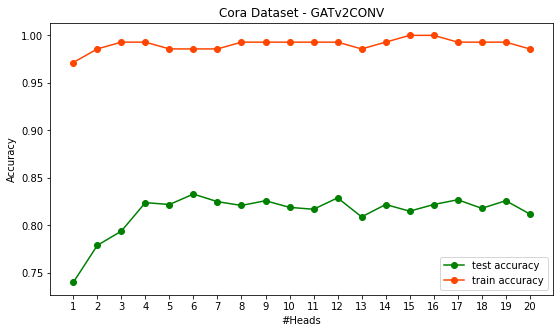

In [13]:
import numpy
plt.figure(figsize=(9,5))
plt.plot(range(1,21), cora_accuracies,'-o',c='g')
plt.plot(range(1,21), cora_train_accuracies,'-o',c='orangered')
plt.xticks(numpy.arange(1,21,1))
plt.title("Cora Dataset - GATv2CONV")
plt.xlabel('#Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

# **Citeseer Dataset**

In [ ]:
name_data = 'Citeseer'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATv2Conv(8 * 8, out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

Number of Classes in Citeseer: 6
Number of Node Features in Citeseer: 3703


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 001, Train: 0.2917, Val: 0.2720, Test: 0.2660
Epoch: 002, Train: 0.3750, Val: 0.3040, Test: 0.2850
Epoch: 003, Train: 0.5417, Val: 0.4280, Test: 0.3730
Epoch: 004, Train: 0.3917, Val: 0.3160, Test: 0.2490
Epoch: 005, Train: 0.3417, Val: 0.2900, Test: 0.2290
Epoch: 006, Train: 0.3667, Val: 0.2760, Test: 0.2160
Epoch: 007, Train: 0.4000, Val: 0.2860, Test: 0.2300
Epoch: 008, Train: 0.4667, Val: 0.3180, Test: 0.2530
Epoch: 009, Train: 0.5500, Val: 0.4180, Test: 0.3360
Epoch: 010, Train: 0.7667, Val: 0.5280, Test: 0.4640
Epoch: 011, Train: 0.8667, Val: 0.6240, Test: 0.6100
Epoch: 012, Train: 0.9000, Val: 0.6660, Test: 0.6630
Epoch: 013, Train: 0.8917, Val: 0.6700, Test: 0.6800
Epoch: 014, Train: 0.9000, Val: 0.6680, Test: 0.6800
Epoch: 015, Train: 0.8750, Val: 0.6300, Test: 0.6740
Epoch: 016, Train: 0.8667, Val: 0.6120, Test: 0.6470
Epoch: 017, Train: 0.8667, Val: 0.6000, Test: 0.6160
Epoch: 018, Train: 0.8417, Val: 0.5880, Test: 0.5990
Epoch: 019, Train: 0.8417, Val: 0.5860, Test: 

### plot accuray

In [ ]:
name_data = 'Citeseer'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

citeseer_accuracies,citeseer_train_accuracies = make_model(dataset,20)

Number of Classes in Citeseer: 6
Number of Node Features in Citeseer: 3703
Epoch: 001, Train: 0.1667, Val: 0.2100, Test: 0.2310
Epoch: 002, Train: 0.1667, Val: 0.2120, Test: 0.2310
Epoch: 003, Train: 0.1667, Val: 0.2120, Test: 0.2310
Epoch: 004, Train: 0.1833, Val: 0.2160, Test: 0.2350
Epoch: 005, Train: 0.2083, Val: 0.2180, Test: 0.2340
Epoch: 006, Train: 0.3000, Val: 0.2280, Test: 0.2490
Epoch: 007, Train: 0.4583, Val: 0.2600, Test: 0.2890
Epoch: 008, Train: 0.5167, Val: 0.2880, Test: 0.3200
Epoch: 009, Train: 0.5000, Val: 0.2360, Test: 0.2730
Epoch: 010, Train: 0.5500, Val: 0.2300, Test: 0.2330
Epoch: 011, Train: 0.6750, Val: 0.2860, Test: 0.2930
Epoch: 012, Train: 0.6833, Val: 0.3420, Test: 0.3200
Epoch: 013, Train: 0.7083, Val: 0.3760, Test: 0.3530
Epoch: 014, Train: 0.6583, Val: 0.3500, Test: 0.3430
Epoch: 015, Train: 0.6667, Val: 0.3760, Test: 0.3490
Epoch: 016, Train: 0.6583, Val: 0.4000, Test: 0.3610
Epoch: 017, Train: 0.7250, Val: 0.4300, Test: 0.3840
Epoch: 018, Train: 0.741

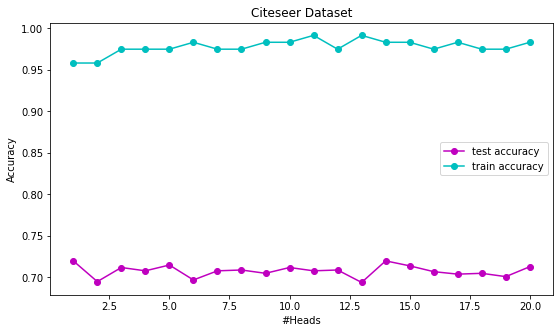

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(range(1,21), citeseer_accuracies,'-o',c='m')
plt.plot( range(1,21), citeseer_train_accuracies,'-o',c='c')
plt.xticks(numpy.arange(1,21,1))

plt.title("Citeseer Dataset  - GATv2CONV ")
plt.xlabel('#Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

# **Pubmed Dataset**

In [8]:
name_data = 'Pubmed'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)
data = dataset[0]

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,heads):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, 8, heads=heads, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATv2Conv(8 * heads, out_channels, heads=8, concat=True,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

Processing...
Done!


Number of Classes in Pubmed: 3
Number of Node Features in Pubmed: 500


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)


def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train(data)
    train_acc, val_acc, test_acc = test(data)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

TypeError: ignored

In [10]:
Pubmed_accuracies,Pubmed_train_accuracies = make_model(dataset,20)

Epoch: 001, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 002, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 003, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 004, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 005, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 006, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 007, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 008, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 009, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 010, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 011, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 012, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 013, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 014, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 015, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 016, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 017, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 018, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 019, Train: 0.3333, Val: 0.3880, Test: 

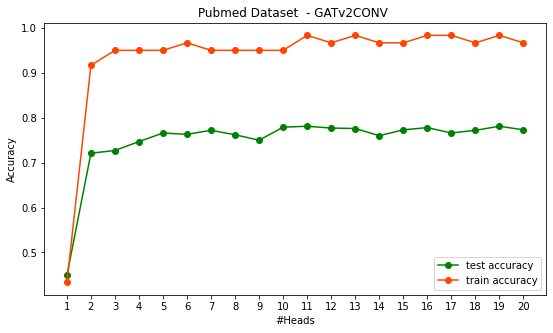

In [17]:
plt.figure(figsize=(9,5))
plt.plot(range(1,21), Pubmed_accuracies,'-o',c='g')
plt.plot( range(1,21), Pubmed_train_accuracies,'-o',c='orangered')
plt.xticks(numpy.arange(1,21,1))

plt.title('Pubmed Dataset  - GATv2CONV ')
plt.xlabel('#Heads')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'])